In [1]:
import math

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5,5, 0.25) # creates an array with values between -5 & 5 and interval of 0.25

In [7]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

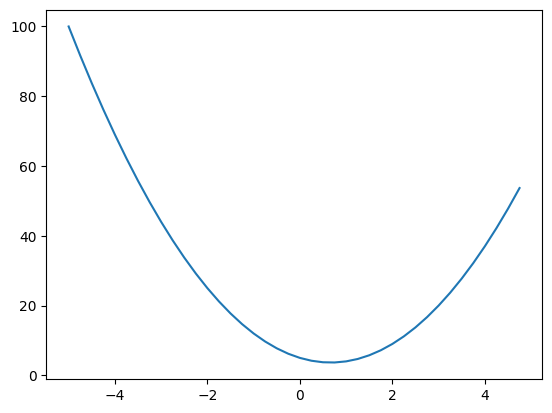

In [8]:
ys = f(xs)
plt.plot(xs,ys)

In [9]:
# lets see if we slightly nudge x value how much function gets effected
h = 0.001
x = 3.0
f(x)

20.0

In [10]:
# lets nudge value of x
f(x+h)

20.014003000000002

In [11]:
# by how much the function responde
f(x+h)-f(x)

0.01400300000000243

In [12]:
# Normalize the function response to get the slope
(f(x+h)-f(x))/h # deravative with respect to x

14.00300000000243

In [13]:
# lets get more complex 
a = 2.0
b = -3.0
c = 10.0

d = a*b+c
print(d)

4.0


In [14]:
# lets get deravative of d with respect to a, b, &c
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c

# deravative of d with respect to d
# so lets nudge a value 
a = a+h
d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

# lets see influence of b on d
a = 2.0 # setting back the same value so we can just see the influence of b on d
b+=h
d3 = a*b+c
print('d3',d3)
print('slope',(d3-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772
d3 4.0002
slope 2.0000000000042206


In [15]:
# neural networks are nothing but huge mathematical expressions
# we need data structures that maintain these expresssions

class Value:
    def __init__(self,data):
        self.data = data

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data)
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
a  # this call the function __repr__

b = Value(-3.0)

# lets try to add a&b using __add__ function
#a.__add__(b)

a+b # internally calls a.__add__(b)

a*b

c = Value(10.0)

a*b+c


Value(data = 4.0)

In [16]:
# because the mathematical expressions are large we need to keep track of all the numbers 
# that are being used to get a certain value in an mathematical expression

# we try to store the values used in the mathematical expression as children

# lets modify the Class Value
class Value:
    def __init__(self,data, _children = ()):
        self.data = data
        self._prev = set(_children)

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other))
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d = a*b+c
d

Value(data = 4.0)

In [17]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [33]:
# now we know the children of the operation that created the result of d but we dont 
# know the mathematical expression that resulted in this value
# so we modify the Value class again

class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other),'+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')
        return out

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0,label = 'f')
L = d*f ; L.label = 'L'
L

Value(data = -8.0)

In [34]:
d._prev

{Value(data = -6.0), Value(data = 10.0)}

In [35]:
d._op

'+'

In [36]:
# becuae these mathematical expresiions will be large we need a way to visualize them neatly

from graphviz import Digraph

def trace(root):
    # builds set of nodes and edges in the graph
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir' : 'LR'}) # LR : left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular node for it
        dot.node(name = uid, label = "{%s | data %.4f}" % (n.label, n.data), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges :
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

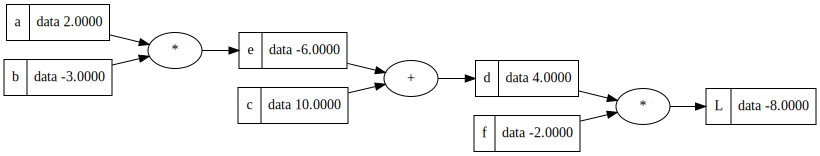

In [38]:
draw_dot(L)

In [67]:
# we will do back propogation
# we will find deravative of L wiht respect to a , b, c, d, e, f

# we will add a new variable to Value class that maintains the derevative of L with respect to the a/b/c/d/e/f

class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other),'+')
        return out
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')
        return out
        

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b
e.label = 'e'
d = e+c
d.label = 'd'
f = Value(-2.0,label = 'f')
L = d*f ; L.label = 'L'
L


Value(data = -8.0)

In [68]:
# becuae these mathematical expresiions will be large we need a way to visualize them neatly

from graphviz import Digraph

def trace(root):
    # builds set of nodes and edges in the graph
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir' : 'LR'}) # LR : left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges :
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

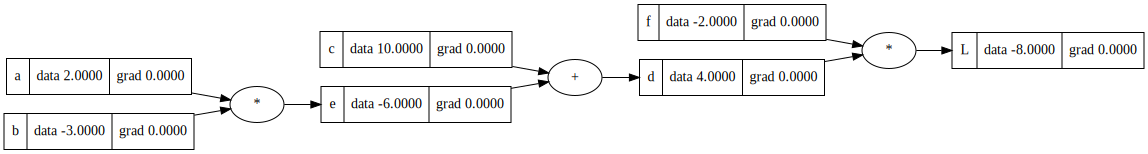

In [69]:
draw_dot(L)

In [70]:
# deravative of L with respect to L is 1

def lol():
    h = 0.0001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label = 'f')
    L = d*f ; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label = 'a') # deravative of L with respect to a
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b
    e.label = 'e'
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label = 'f')
    L = d*f ; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h) # deravative of L with respect to a

lol()

6.000000000021544


In [71]:
L.grad = 1.0

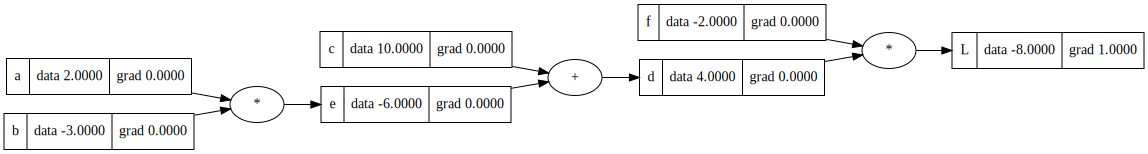

In [72]:
draw_dot(L)

# BackPropogation

In [73]:

# deravative of L with respect to d
# deravative formaula (f(x+h)-f(x))/h
# dL/dd = ((d+h)*f - d*f)/h
# (d*f + h*f - d*f)/h  => h*f/h  => f

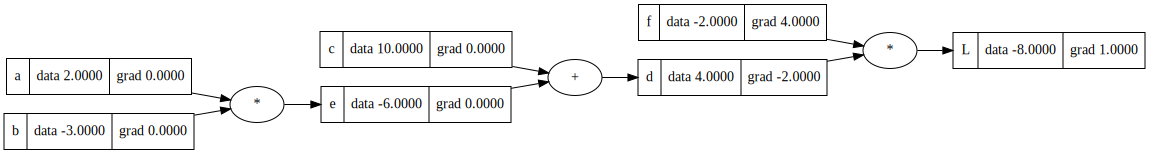

In [74]:
# so we update the grad values of node f and d
# grad value at node f indicates deravative of L with respect to f. In this case it is nothing but d

f.grad = 4.0

# similar to f
d.grad = -2.0

draw_dot(L)

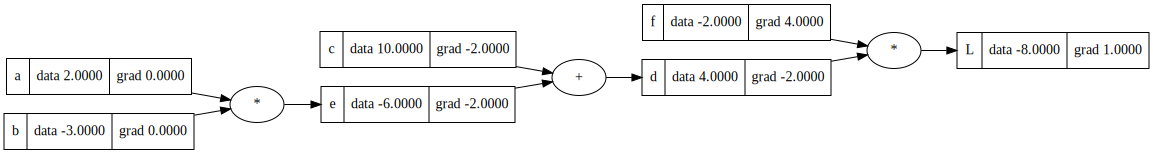

In [75]:
# Now lets calculative of derevative of L with respect to c
# L = d*f
# d = c+e
# => we can first see how much d gets impacted by c  dd/dc
# ((c+h + e)-(c+e))/h => (c+h+e-c-e)/h => h/h => 1

# => dd/dc = 1 also similar to this dd/de = 1

# Now dL/dc = dL/dd * dd/dc => -2 * 1 = -2
# dL/de = dL/dd * dd/de => -2 * 1 = -2

# lets upgrade the grad values of d and e

c.grad = -2
e.grad = -2

draw_dot(L)


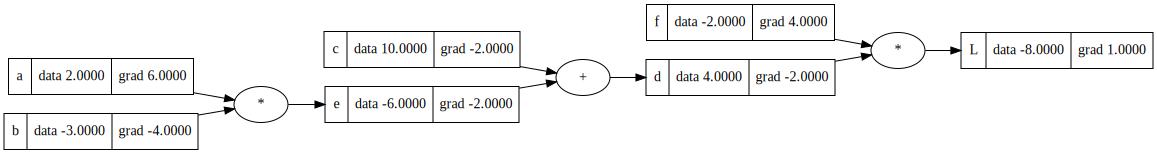

In [76]:
# Now we will calculate the impact of b on L
# L = d*f
# L = (c+e) * f
# L = (c + (a*b)) * f

# e= a * b

# deravative of e with respect to b
# de/db = (a*(b+h) - a*b)/h => (a*b + a*h - a*b)/h => a*h/h => a
# de/da = ((a+h)*b - a*b)/h => (a*b + b*h - a*b)/h => b*h/h => b

# now dervative of d with respect to a
# dL/da = dL/de * de/da
# dL/da = -2 * -3 => 6
# dL/db = dL/de * de/db
# dL/db = -2 * 2 => -4

a.grad = 6
b.grad = -4

draw_dot(L)

In [77]:
# let try to improve L to +ve
# for L to hae +ve impact we need to go in the direction of the gradient

a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b
d = e+c
L = d*f

print(L.data)


-7.286496


In [78]:
# Having a gradient is helping us to know how much L gets impacted by nudging values of a, b, c, d, e, f

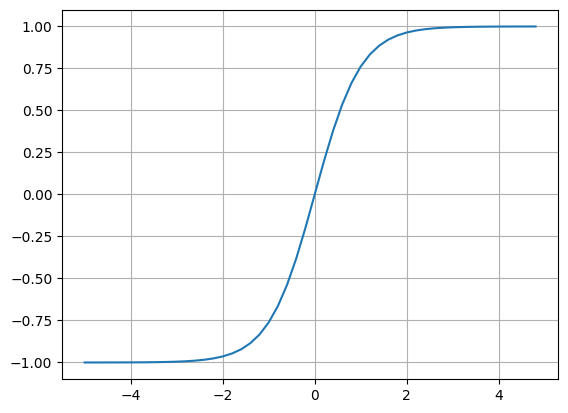

In [79]:
# lets try to implement the same backpropogation on the slightly complicated mathematical equation

# lets take a neuron . It will have inputs (x) with some weights (w). We add all of them sum(w*x) to this we neuron adds its bias (b) and 
# then we pass it through the activation function which tries to put these values between 0 & 1

# lets see what happens if the activation function is tanh
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2)))
plt.grid()

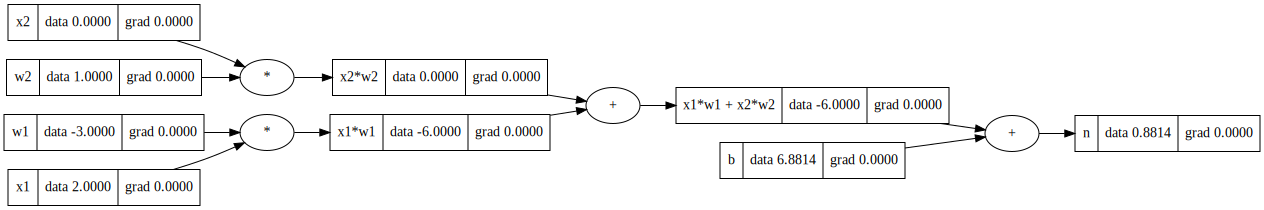

In [82]:
# inputs x1, x2
# weights w1, w2
# bias = b

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

draw_dot(n)

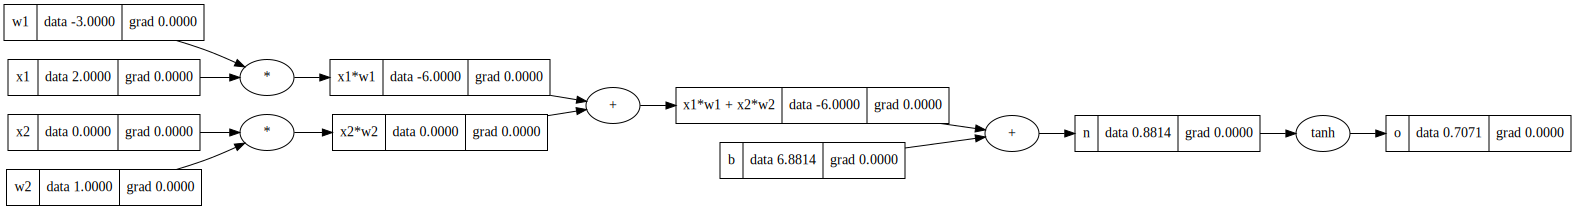

In [84]:
o = n.tanh()
o.label = 'o'
draw_dot(o)


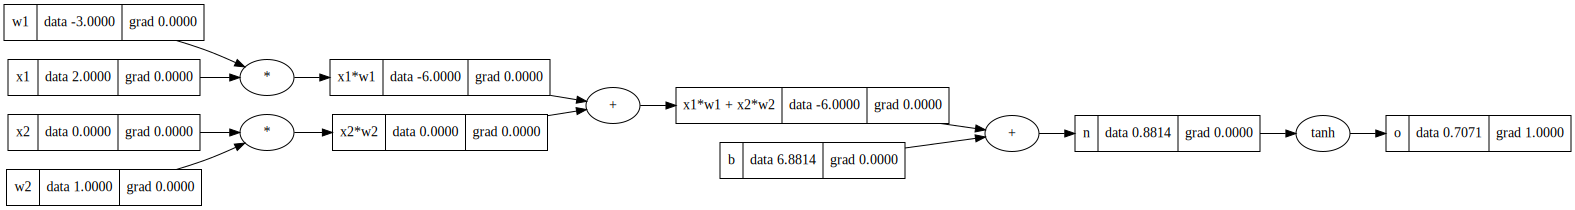

In [86]:
# lets try to do deravative of all these nodes => backpropogation
# deravative of o with respect to o is 1.0
o.grad = 1.0
draw_dot(o)

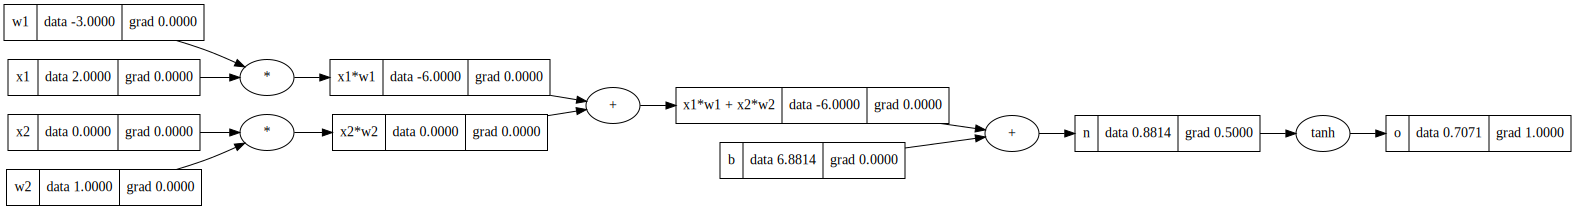

In [88]:
# lets see deravative of o wioth respect to n
# o = tanh(n)
# do/dn = 1-tanh(n)**2
#do/dn = 1-o**2 => 1-o.data**2

n.grad = 1-o.data**2
draw_dot(o)


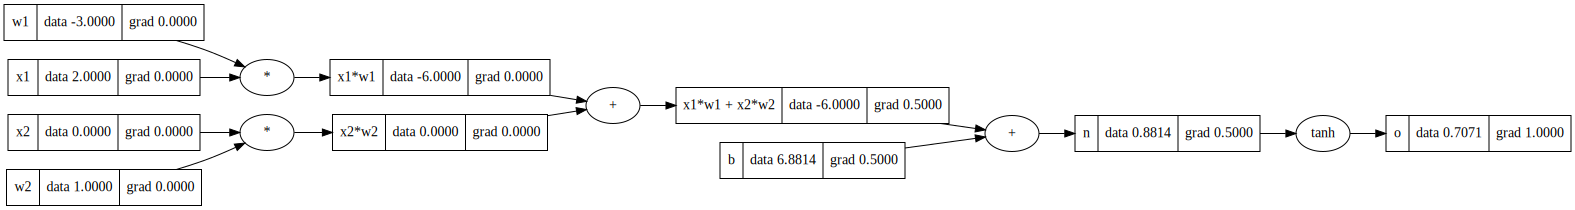

In [89]:
# In the above cells we have seen with '+' operation the grad that does not change
# so the deravative of o with respect to x1w1x2w2 will be same as derevative of o with respect to n
x1w1x2w2.grad = 0.5
b.grad = 0.5

draw_dot(o)

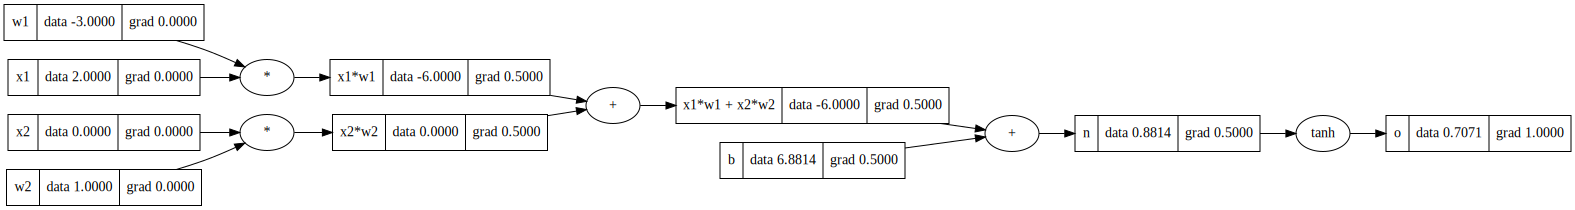

In [90]:
# one more + operation 
x1w1.grad = 0.5
x2w2.grad = 0.5

draw_dot(o)

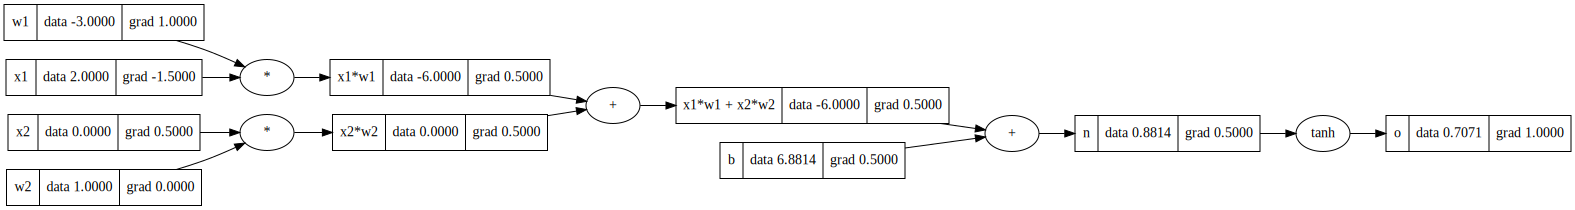

In [91]:
# now back propogating to x1w1
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

In [98]:
# Automate the backpropogation

class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # backpropagation function

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
        
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other),'+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
            
        out._backward = _backward
        return out
        

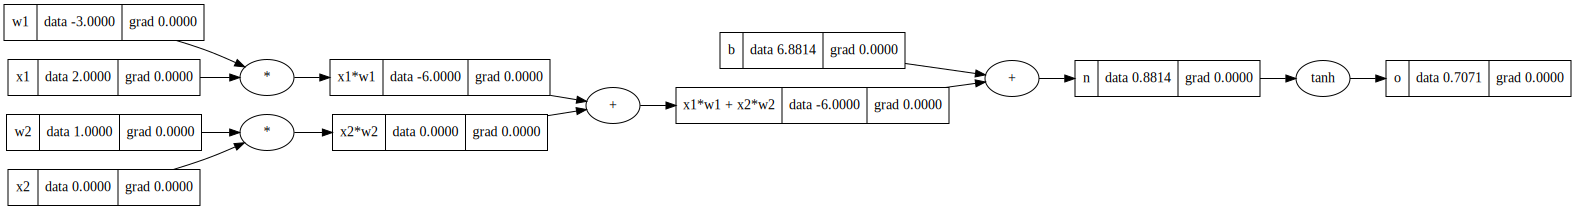

In [108]:
# inputs x1, x2
# weights w1, w2
# bias = b

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

o = n.tanh()
o.label = 'o'

draw_dot(o)

In [100]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

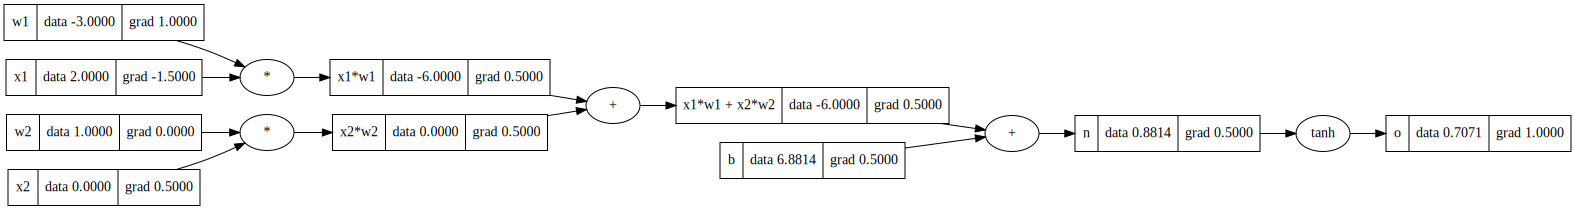

In [101]:
draw_dot(o)

In [102]:
# now lets automate calling _backward() 
# But before we call _backward() on a node we need to be done with everything thats after that node.
# we achieve this by using TOPOLOGICAL SORT => makes sure the graph is in one  direction left to right

# simply put this give list of nodes from top to bottom

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo  

[Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = -6.0),
 Value(data = 6.881373587019543),
 Value(data = 0.8813735870195432),
 Value(data = 0.7071067811865476)]

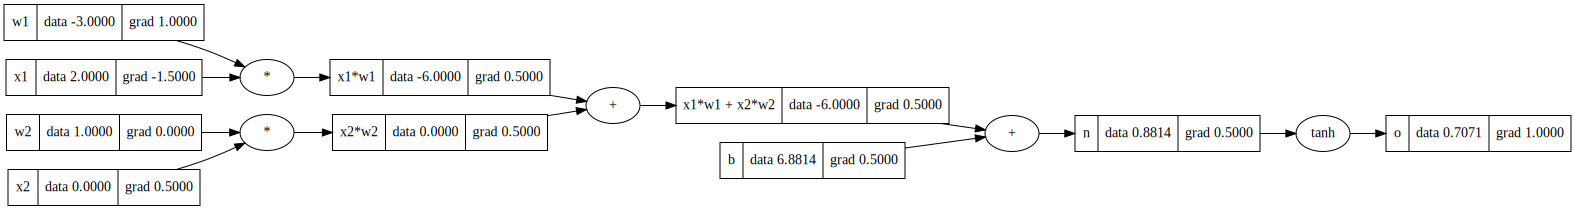

In [103]:
# now we will call the _bakward() in reverse of topological order

o.grad = 1.0

for node in reversed(topo):
    node._backward()

draw_dot(o)

In [106]:
# lets make all this backpropogation thing into Value class
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # backpropagation function

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
        
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other),'+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')

        def _backward():
            self.grad = (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

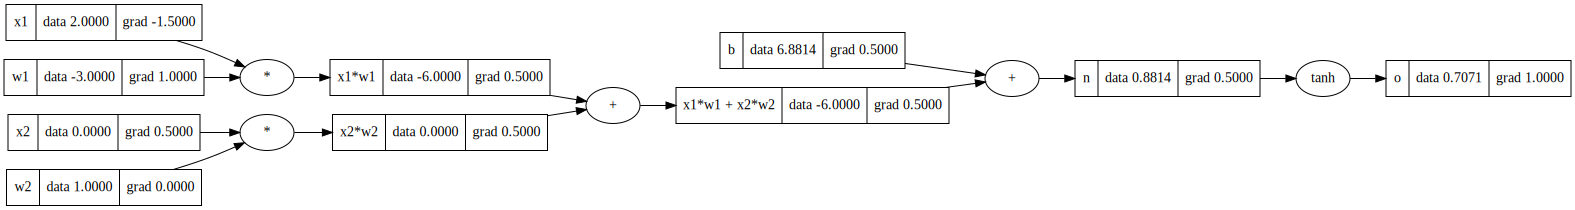

In [110]:
# inputs x1, x2
# weights w1, w2
# bias = b

x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()
draw_dot(o)

# fixing backpropogation bug that occurs when one node is used


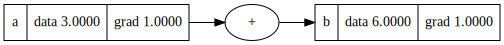

In [111]:
# example
a = Value(3.0 , label = 'a')
b = a+a ; b.label = 'b'
b.backward()
draw_dot(b)

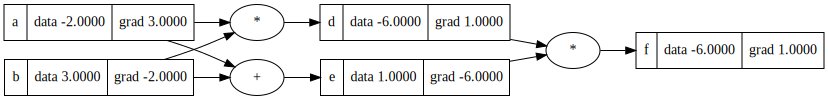

In [113]:
a = Value(-2.0 , label = 'a')
b = Value(3.0 , label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()
draw_dot(f)
# gradient values of a and b are impacted by 2 operations + and * but for now storing only last operation impacts
# this can be solved by accumulating gradients of variables at every operation

In [114]:
# if a variable is used more than once the gradients are being replaced with the latest gradients
# so we are  doing minor changes to Value function
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # backpropagation function

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
        
    def __add__(self,other): # we use __ to define operators like + between value objects
        out = Value(self.data+other.data , (self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad # adding up the gradients to avoid error when using same variable at multiple places
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

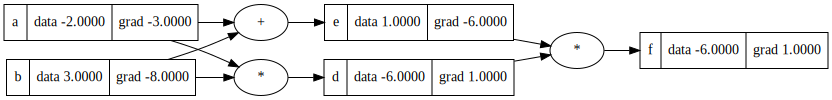

In [115]:
# lets see the vhanges now
a = Value(-2.0 , label = 'a')
b = Value(3.0 , label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()
draw_dot(f)

In [116]:
# break down tanh into basic internal operations . The gradients will still be sthe same though we break down tanh into multiple tiny operations

# to allow the simple numbers to be operated with Value object we modify the Value class to take in the number and turn it into the Value object

class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # backpropagation function

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
        
    def __add__(self,other): # we use __ to define operators like + between value objects
        # if passed arg is a number wrap it into a Value object
        other = other if isinstance(other,Value) else Value(other) # problem here is only a+1 will work 1+a will fail
        out = Value(self.data+other.data , (self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad # adding up the gradients to avoid error when using same variable at multiple places
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [117]:
a = Value(2.0)
a+1

Value(data = 3.0)

In [118]:
a*2

Value(data = 4.0)

In [119]:
2*a # fails .expected because in mul function we are only wrapping the 2nd argument to Value object not the first one

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [120]:
1+a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [138]:
class Value:
    def __init__(self,data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None # backpropagation function

    def __repr__(self):
        return f"Value(data = {self.data})"   # prints the value when object is tried to print
        
    def __add__(self,other): # we use __ to define operators like + between value objects
        # if passed arg is a number wrap it into a Value object
        other = other if isinstance(other,Value) else Value(other) # problem here is only a+1 will work 1+a will fail
        out = Value(self.data+other.data , (self,other),'+')
        
        def _backward():
            self.grad += 1.0 * out.grad # adding up the gradients to avoid error when using same variable at multiple places
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self+other
        
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self,other): # other * self =>swap the order of the arguments and pass them to __mul__
        return self*other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t , (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x) , (self, ), 'exp')

        def _backward():
            self.grad += out.data *out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other): # self/other
        return self* other**-1

    def __pow__(self,other):
        assert isinstance(other,(int, float)) , " Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad+= other*(self.data**(other-1))*out.grad
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self*-1

    def __sub__(self,other): # self-other
        return self+(-other)
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [139]:
a  = Value(2.0)
a+1

Value(data = 3.0)

In [140]:
1+a

Value(data = 3.0)

In [141]:
a*2

Value(data = 4.0)

In [142]:
2*a

Value(data = 4.0)

In [143]:
a = Value(2.0)
b = Value(4.0)

a/b

Value(data = 0.5)

In [144]:
a-b

Value(data = -2.0)

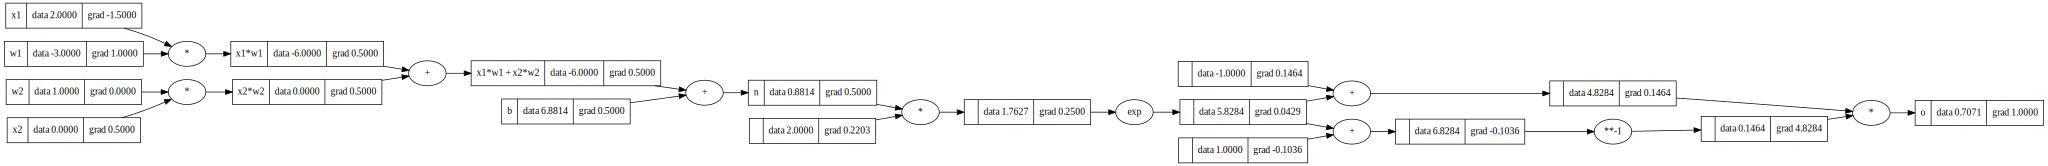

In [145]:
x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')
w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'
# ---- changing tanh computation
#o = n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
# ----
o.label = 'o'

o.backward()
draw_dot(o)

In [147]:
# doing the same above calculation using Pytorch
# python default uses doiuble precision so we are casting tensors to double

import torch
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2' , x2.grad.item())
print('w2' , w2.grad.item())
print('x1' , x1.grad.item())
print('w1' , w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [148]:
o.data

tensor([0.7071], dtype=torch.float64)

# Build Neural Network

In [151]:
import random
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w , x)) , self.b) # zip function : w's will be paired up with x's
        out = act.tanh()
        return out

# lets try with single neuron
x = [2.0,3.0]
n = Neuron(2)
n(x)
        

Value(data = 0.8385511081019325)

In [157]:
# lets go ahead and add layers
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w , x)) , self.b) # zip function : w's will be paired up with x's
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

# lets try it 3 layers with each layer having 2 neurons
x = [2.0,3.0]
n = Layer(2, 3)
n(x)

[Value(data = 0.5162135420155796),
 Value(data = 0.9832601769411834),
 Value(data = -0.996059233579666)]

In [168]:
# lets build multi layer perceptron Nothing but a deep neural network
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w , x)) , self.b) # zip function : w's will be paired up with x's
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # just trying to avoid list when the list if single element

class MLP:

    def __init__(self, nin, nouts) : # takes in number of layers and list number of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# lets try to create 3 input neurons and then 2 layers with 4 neurons and 1 output

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.5835253366383161)

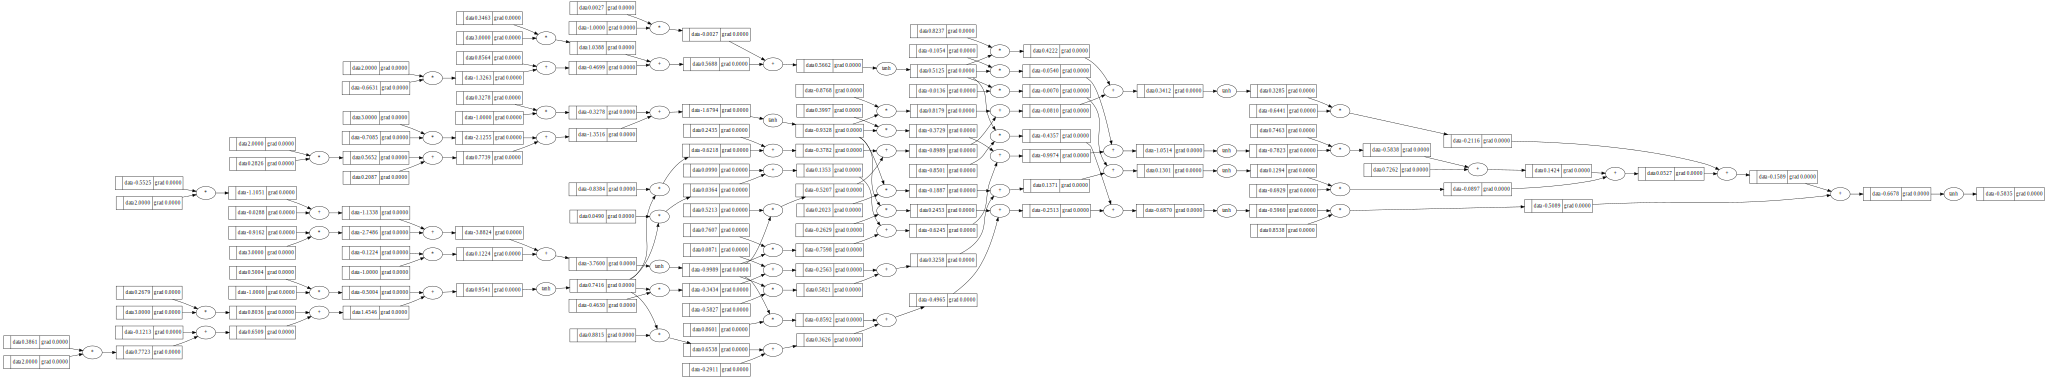

In [169]:
draw_dot(n(x))

In [170]:
# lets try to create a simple binary classifier predictor deep neural network
# inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs
ypred = [n(x) for x in xs]
ypred # predictions for now by neural network


[Value(data = -0.5835253366383161),
 Value(data = 0.899201254211733),
 Value(data = -0.38535705639629236),
 Value(data = -0.8232842294452206)]

In [173]:
# we did not get the desired out. So trying to improve the predictions
# we calculate loss : Measures how well the neural network is performing
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data = 9.816669225240396)

In [174]:
# our aim is to reduce the loss
loss.backward()

In [177]:
n.layers[0].neurons[0].w[0].grad # checking if the neuron is impacting the result

-2.2084694703468806

In [235]:
# we need the list of all the parameters that the MLP is using so we can nudge the values and improve the loss value
# we add function called parameters
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w , x)) , self.b) # zip function : w's will be paired up with x's
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b] 

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # just trying to avoid list when the list if single element

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
       # params = []
       # for neuron in self.neurons:
       #     ps = neuron.parameters()
       #     params.extend(ps)
       # return params

class MLP:

    def __init__(self, nin, nouts) : # takes in number of layers and list number of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [236]:
# lets try to create 3 input neurons and then 2 layers with 4 neurons and 1 output

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = -0.055169110036161706)

In [237]:
n.parameters() # gives weights and biases 

[Value(data = -0.13295501164040857),
 Value(data = -0.7588793580919893),
 Value(data = -0.2621746890935355),
 Value(data = 0.3598293694824779),
 Value(data = 0.007795286107104893),
 Value(data = -0.581257049071374),
 Value(data = 0.943066056353467),
 Value(data = 0.1443070581970789),
 Value(data = -0.1046228441530408),
 Value(data = 0.5674283293678344),
 Value(data = 0.9638392898237373),
 Value(data = -0.96009209802004),
 Value(data = 0.9034293293933444),
 Value(data = 0.1118185787178112),
 Value(data = -0.8128453211641502),
 Value(data = -0.9548377085850639),
 Value(data = 0.3588410396365096),
 Value(data = -0.36256130607144166),
 Value(data = -0.09337517368122605),
 Value(data = 0.5312209286925864),
 Value(data = -0.8803458557412938),
 Value(data = 0.19501025131433214),
 Value(data = -0.8890913496885922),
 Value(data = 0.012638907341247174),
 Value(data = 0.14275310970717436),
 Value(data = 0.9175575165477732),
 Value(data = -0.6158072919394169),
 Value(data = -0.5581494247779186),
 

In [221]:
# lets try to create a simple binary classifier predictor deep neural network
# inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs
ypred = [n(x) for x in xs]
ypred # predictions for now by neural network


[Value(data = -0.5731365542844195),
 Value(data = -0.4051781695756181),
 Value(data = -0.5086784607018295),
 Value(data = -0.47775910471271404)]

In [222]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data = 5.253740454914915)

In [223]:
loss.backward()

In [224]:
n.layers[0].neurons[0].w[0].grad

-0.10871014083760094

In [225]:
n.layers[0].neurons[0].w[0].grad

-0.10871014083760094

In [226]:
# lets try to change the parameters a little bit
for p in n.parameters():
    p.data += -0.01 * p.grad # we need to minimize the loss so we need to decrease the gradient
    

In [229]:
# once the parameters are slightly notched lets se how it effects
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs
ypred = [n(x) for x in xs]
ypred # predictions for now by neural network

[Value(data = -0.45714582298760414),
 Value(data = -0.2798758596448477),
 Value(data = -0.46817760588805346),
 Value(data = -0.3716229501645468)]

In [230]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss # loss has slightly improved

Value(data = 4.806037303269527)

In [231]:
# our aim is to reduce the loss
loss.backward()

In [241]:
# lets try to implement a training loop
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired outputs

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt , yout in zip(ys, ypred))

    # backward pass
     # we need to make usure all the gradients are set to 0.0 so the backward pass works as expected
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
   
    

    # update the parameters => gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad # learning rate here is set to -0.05

    print(k, loss.data)

0 8.003366699873281e-11
1 8.003366487125005e-11
2 8.003366274376731e-11
3 8.003366061628461e-11
4 8.003365848681532e-11
5 8.003365635933267e-11
6 8.003365423185005e-11
7 8.003365210436745e-11
8 8.00336499768849e-11
9 8.003364784940237e-11
10 8.003364571993341e-11
11 8.003364359245093e-11
12 8.003364146496848e-11
13 8.003363933748607e-11
14 8.003363721000366e-11
15 8.00336350825213e-11
16 8.003363295305252e-11
17 8.003363082557022e-11
18 8.003362869808793e-11
19 8.003362657060568e-11


In [242]:
ypred # predictions are much closer to the actual values

[Value(data = 0.9999910538485403),
 Value(data = -0.9999999999960102),
 Value(data = -0.9999999999957762),
 Value(data = 0.9999999992063348)]